# NIH Chest X-ray Multi label Binary classification using Tensorflow Densenet121 (Transfer learning)


## Imports

In [1]:
import os

# Set environment variables
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.random.set_seed(42)

2025-03-02 11:57:33.146997: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740916653.161815   84762 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740916653.166532   84762 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
found_gpu = tf.config.list_physical_devices('GPU')
if not found_gpu:
    raise Exception("No GPU found")
found_gpu, tf.__version__

([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')], '2.18.0')

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pathlib import Path
import opendatasets as od

from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

## Constants

In [4]:

IMAGE_SIZE = 320
BATCH_SIZE = 16

## Download the dataset


In [5]:
dataset_url = 'https://www.kaggle.com/datasets/nih-chest-xrays/sample'

# Look into the data directory
datasets = 'datasets/sample'
dataset_path = Path(datasets)
IMAGE_DIR = dataset_path /'sample/images'
CSV_PATH = dataset_path /'sample/sample_labels.csv'
dataset_path.mkdir(parents=True, exist_ok=True)
if not dataset_path.is_dir():
    od.download(dataset_url)

## Load Datasets

In [ ]:
sample_df = pd.read_csv(CSV_PATH)
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5606 entries, 0 to 5605
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  5606 non-null   object 
 1   Finding Labels               5606 non-null   object 
 2   Follow-up #                  5606 non-null   int64  
 3   Patient ID                   5606 non-null   int64  
 4   Patient Age                  5606 non-null   object 
 5   Patient Gender               5606 non-null   object 
 6   View Position                5606 non-null   object 
 7   OriginalImageWidth           5606 non-null   int64  
 8   OriginalImageHeight          5606 non-null   int64  
 9   OriginalImagePixelSpacing_x  5606 non-null   float64
 10  OriginalImagePixelSpacing_y  5606 non-null   float64
dtypes: float64(2), int64(4), object(5)
memory usage: 481.9+ KB


In [ ]:
sample_df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImageWidth',
       'OriginalImageHeight', 'OriginalImagePixelSpacing_x',
       'OriginalImagePixelSpacing_y'],
      dtype='object')

In [ ]:
train_csv= 'datasets/train-small.csv'
valid_csv= 'datasets/valid-small.csv'
test_csv= 'datasets/test.csv'

train_df = pd.read_csv(f"{train_csv}")
valid_df = pd.read_csv(f"{valid_csv}")

test_df = pd.read_csv(f"{test_csv}")

## Data Clean up

In [ ]:
sample_df.head(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168
5,00000040_003.png,Consolidation|Mass,3,40,068Y,M,PA,2500,2048,0.168,0.168
6,00000042_002.png,No Finding,2,42,071Y,M,AP,3056,2544,0.139,0.139
7,00000057_001.png,No Finding,1,57,071Y,M,AP,3056,2544,0.139,0.139
8,00000061_002.png,Effusion,2,61,077Y,M,PA,2992,2991,0.143,0.143
9,00000061_019.png,No Finding,19,61,077Y,M,AP,3056,2544,0.139,0.139


### Unique check

In [ ]:
sample_df['Patient ID'].count(),sample_df['Patient ID'].nunique()

(5606, 4230)

Droping duplicates

In [ ]:
sample_df.drop_duplicates(subset=['Patient ID'], inplace=True)
sample_df['Patient ID'].nunique()


4230

### Prepare new csv file with useful information and format

In [ ]:
useful_data_df= sample_df[['Image Index', 'Finding Labels']]
useful_data_df.head()

,Image Index,Finding Labels
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...
2,00000017_001.png,No Finding
3,00000030_001.png,Atelectasis
4,00000032_001.png,Cardiomegaly|Edema|Effusion
5,00000040_003.png,Consolidation|Mass


In [12]:
len(useful_data_df)

4230

In [13]:
from collections import Counter
def get_most_common_label(labels):
    return Counter(labels.split('|')).most_common(1)[0][0]

In [14]:
# Create a new column with the most common label for each row
useful_data_df['primary_label'] = useful_data_df['Finding Labels'].apply(get_most_common_label)
useful_data_df

/tmp/ipykernel_84762/3436370036.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  useful_data_df['primary_label'] = useful_data_df['Finding Labels'].apply(get_most_common_label)


,Image Index,Finding Labels,primary_label
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,Emphysema
2,00000017_001.png,No Finding,No Finding
3,00000030_001.png,Atelectasis,Atelectasis
4,00000032_001.png,Cardiomegaly|Edema|Effusion,Cardiomegaly
5,00000040_003.png,Consolidation|Mass,Consolidation
...,...,...,...
5601,00030712_000.png,No Finding,No Finding
5602,00030786_005.png,Cardiomegaly|Effusion|Emphysema,Cardiomegaly
5603,00030789_000.png,Infiltration,Infiltration
5604,00030792_000.png,No Finding,No Finding


In [15]:
useful_data_df = useful_data_df.dropna()

In [16]:
images_df = useful_data_df['Image Index'] 

In [17]:
useful_data_df.primary_label

0           Emphysema
2          No Finding
3         Atelectasis
4        Cardiomegaly
5       Consolidation
            ...      
5601       No Finding
5602     Cardiomegaly
5603     Infiltration
5604       No Finding
5605       No Finding
Name: primary_label, Length: 4230, dtype: object

In [18]:
images_df

0       00000013_005.png
2       00000017_001.png
3       00000030_001.png
4       00000032_001.png
5       00000040_003.png
              ...       
5601    00030712_000.png
5602    00030786_005.png
5603    00030789_000.png
5604    00030792_000.png
5605    00030797_000.png
Name: Image Index, Length: 4230, dtype: object

In [19]:
# Perform stratified split
X_train, X_test, y_train, y_test = train_test_split(images_df, useful_data_df.primary_label, test_size=0.1, random_state=42, stratify=useful_data_df.primary_label)

### One hot encoding

In [20]:
# drop_colums = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
#        'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding',
#        'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
# 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
drop_colums = [
       'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding',
       'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

In [21]:
categorical_labels_df = y_train.str.get_dummies(sep='|').astype('float32')
categorical_labels_df.columns

Index(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
       'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding',
       'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'],
      dtype='object')

In [22]:
categorical_labels_df.drop(drop_colums, inplace=True, axis=1)
labels = categorical_labels_df.columns

In [23]:
categorical_y_test = y_test.str.get_dummies(sep='|').astype('float32')
categorical_y_test.columns

Index(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
       'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding',
       'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'],
      dtype='object')

In [24]:
categorical_y_test.drop(drop_colums, inplace=True, axis=1)
categorical_y_test.columns

Index(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion'], dtype='object')

In [25]:
len(categorical_y_test),len(X_test)

(423, 423)

### Load Training Dataset from Dataframe

In [26]:
def load_image(image_name, label):
    full_path = tf.strings.join([f'{IMAGE_DIR}/', image_name])
    image = tf.io.read_file(full_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])  # Resize to the desired size
    label = tf.cast(label, tf.float32)
    return image, label


In [27]:
len(X_train)

3807

In [28]:
len(categorical_labels_df.values)

3807

In [29]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.data.Dataset.from_tensor_slices((X_train,  categorical_labels_df.values))
train_ds = train_ds.map(load_image, num_parallel_calls=AUTOTUNE)

I0000 00:00:1740916655.874999   84762 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7258 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:0a:00.0, compute capability: 8.6


In [30]:
valid_ds = tf.data.Dataset.from_tensor_slices((X_test,  categorical_y_test.values))
valid_ds = valid_ds.map(load_image, num_parallel_calls=AUTOTUNE)

## Image Processing

#### Normalization

In [31]:
# Create normalization layer
normalization_layer = tf.keras.layers.Normalization()
# Compute the mean and variance using the training data
# We need to convert the dataset to numpy to compute statistics
images_for_stats = []
for images, _ in train_ds.take(int(len(X_train)*0.25)): 
    images_for_stats.append(images)
images_for_stats = tf.concat(images_for_stats, axis=0)
normalization_layer.adapt(images_for_stats)

#### Augmentation 

In [32]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.10),                    # Small rotation
    tf.keras.layers.RandomTranslation(0.05, 0.05),           # Translation
    tf.keras.layers.RandomContrast(0.1),                     # Contrast adjustment
    tf.keras.layers.RandomBrightness(0.1),                   # Brightness adjustment
    tf.keras.layers.RandomZoom(0.1, 0.1)])                   # Random zoom

In [33]:
def preprocess_image(image, label):
    image = tf.cast(image, tf.float32) #/ 255.0
    # image = tf.keras.applications.densenet.preprocess_input(image)
    image = normalization_layer(image)
    return image, label

In [34]:
train_ds = train_ds.map(lambda image, label: (data_augmentation(image), label) , num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(preprocess_image,num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).shuffle(len(X_train))
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

In [35]:
for batch in train_ds.take(1):
    print(batch[0].shape)
    image, label = batch
    print(image[0], label[0])

(16, 320, 320, 3)
tf.Tensor(
[[[ 0.3588032   0.3588032   0.3588032 ]
  [ 0.44502568  0.44502568  0.44502568]
  [ 0.45922473  0.45922473  0.45922473]
  ...
  [-0.28343937 -0.28343937 -0.28343937]
  [-0.29175162 -0.29175162 -0.29175162]
  [-0.34251    -0.34251    -0.34251   ]]

 [[ 0.33559498  0.33559498  0.33559498]
  [ 0.43576556  0.43576556  0.43576556]
  [ 0.4522546   0.4522546   0.4522546 ]
  ...
  [-0.23386687 -0.23386687 -0.23386687]
  [-0.24177174 -0.24177174 -0.24177174]
  [-0.29180217 -0.29180217 -0.29180217]]

 [[ 0.32912573  0.32912573  0.32912573]
  [ 0.4306468   0.4306468   0.4306468 ]
  [ 0.44737172  0.44737172  0.44737172]
  ...
  [-0.24848486 -0.24848486 -0.24848486]
  [-0.25161013 -0.25161013 -0.25161013]
  [-0.26749498 -0.26749498 -0.26749498]]

 ...

 [[ 1.161799    1.161799    1.161799  ]
  [ 1.1418097   1.1418097   1.1418097 ]
  [ 1.1384953   1.1384953   1.1384953 ]
  ...
  [ 1.0151496   1.0151496   1.0151496 ]
  [ 1.0144291   1.0144291   1.0144291 ]
  [ 1.0066046  

In [36]:
valid_ds = valid_ds.map(preprocess_image,num_parallel_calls=tf.data.AUTOTUNE)
valid_ds = valid_ds.batch(BATCH_SIZE)
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)

### Class Imbalance Handling

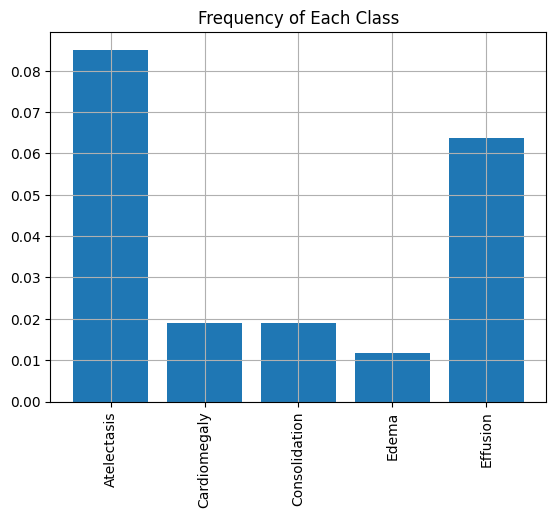

In [37]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(categorical_y_test, axis=0))
plt.title("Frequency of Each Class")
plt.grid()
plt.show()

#### Compute Class Frequencies

In [38]:
N = categorical_labels_df.shape[0]
positive_frequencies = (categorical_labels_df==1).sum()/N
negative_frequencies = (categorical_labels_df==0).sum()/N
positive_frequencies, negative_frequencies

(Atelectasis      0.084056
 Cardiomegaly     0.019701
 Consolidation    0.019175
 Edema            0.013134
 Effusion         0.063304
 dtype: float64,
 Atelectasis      0.915944
 Cardiomegaly     0.980299
 Consolidation    0.980825
 Edema            0.986866
 Effusion         0.936696
 dtype: float64)

In [39]:
data_df = pd.DataFrame(list(positive_frequencies.items()), columns=['class', 'positives'])
data_df['negatives'] = negative_frequencies.values
data_df

,class,positives,negatives
0,Atelectasis,0.084056,0.915944
1,Cardiomegaly,0.019701,0.980299
2,Consolidation,0.019175,0.980825
3,Edema,0.013134,0.986866
4,Effusion,0.063304,0.936696


<Axes: xlabel='class'>

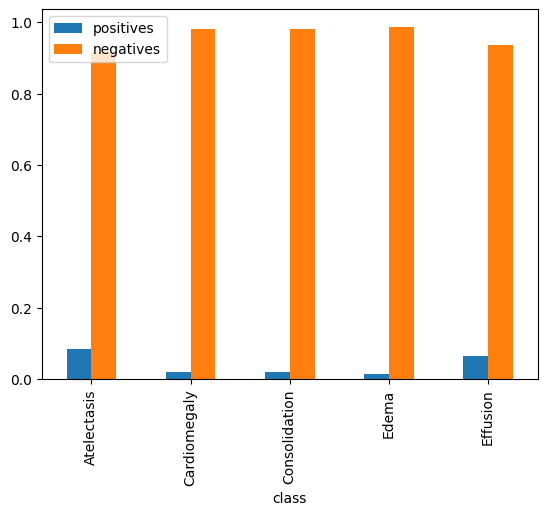

In [40]:
data_df.plot.bar(x='class')

As we see in the above plot, the contributions of positive cases is significantly lower than that of the negative ones. However, we want the contributions to be equal. One way of doing this is by multiplying each example from each class by a class-specific weight factor, $w_{pos}$ and $w_{neg}$, so that the overall contribution of each class is the same. 

To have this, we want 

$$w_{pos} \times freq_{p} = w_{neg} \times freq_{n},$$

which we can do simply by taking 

$$w_{pos} = freq_{neg}$$
$$w_{neg} = freq_{pos}$$

This way, we will be balancing the contribution of positive and negative labels.

In [41]:
pos_weights = negative_frequencies.values
neg_weights = positive_frequencies.values
# positive_frequencies.values

# Try adjusting the weight balance slightly
# pos_weights = np.sqrt(negative_frequencies.values) * 0.8  # Reduce positive weight slightly
# neg_weights = np.sqrt(positive_frequencies.values) * 1.2  # Increase negative weight slightly

In [42]:
pos_contirbution = positive_frequencies * pos_weights
neg_contribution = negative_frequencies * neg_weights

pos_contirbution, neg_contribution

(Atelectasis      0.076990
 Cardiomegaly     0.019312
 Consolidation    0.018808
 Edema            0.012961
 Effusion         0.059297
 dtype: float64,
 Atelectasis      0.076990
 Cardiomegaly     0.019312
 Consolidation    0.018808
 Edema            0.012961
 Effusion         0.059297
 dtype: float64)

In [43]:
weighted_data_df = pd.DataFrame(list(pos_contirbution.items()), columns=['class', 'positives'])
weighted_data_df['negatives'] = neg_contribution.values
weighted_data_df

,class,positives,negatives
0,Atelectasis,0.076990,0.076990
1,Cardiomegaly,0.019312,0.019312
2,Consolidation,0.018808,0.018808
3,Edema,0.012961,0.012961
4,Effusion,0.059297,0.059297


<Axes: xlabel='class'>

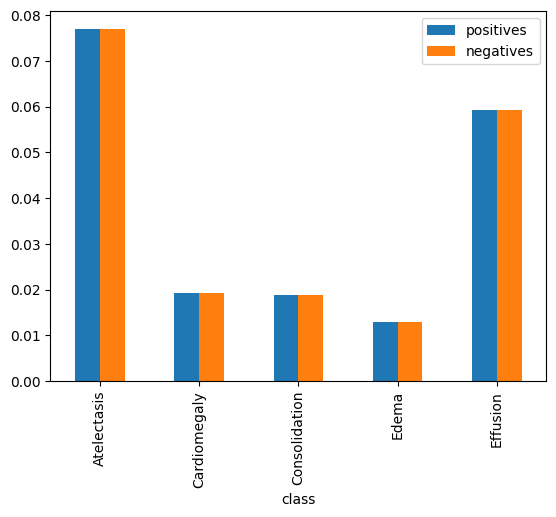

In [44]:
weighted_data_df.plot.bar(x='class')

## Weighted loss calculation to handle class imbalance

As the above figure shows, by applying these weightings the positive and negative labels within each class would have the same aggregate contribution to the loss function. Now let's implement such a loss function. 

After computing the weights, our final weighted loss for each training case will be 

$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

In [45]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0

        for i in range(len(pos_weights)):
            y = y_true[:, i]
            f_of_x = y_pred[:, i]

            f_of_x_log = K.log(f_of_x + epsilon)
            f_of_x_1_min_log = K.log((1-f_of_x) + epsilon)

            first_term = pos_weights[i] * y * f_of_x_log
            sec_term = neg_weights[i] * (1-y) * f_of_x_1_min_log
            loss_per_col = - K.mean(first_term + sec_term)
            loss += loss_per_col
        return loss

    return weighted_loss



## Model Development

### Load and Prepare DenseNet121 Model

In [46]:
#'imagenet',

base_model = DenseNet121(
     include_top=False,
     weights='imagenet', 
     input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)  
)
# base_model.trainable = False


x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(4096, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)

# def conv_block(filters):
#     block = tf.keras.Sequential([
#         tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
#         tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.MaxPool2D()
#     ]
#     )
    
#     return block
# def dense_block(units, dropout_rate):
#     block = tf.keras.Sequential([
#         tf.keras.layers.Dense(units, activation='relu'),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dropout(dropout_rate)
#     ])
    
#     return block

# def build_model():
#     model = tf.keras.Sequential([
#         tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        
#         tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
#         tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
#         tf.keras.layers.MaxPool2D(),
        
#         conv_block(32),
#         conv_block(64),
        
#         conv_block(128),
#         tf.keras.layers.Dropout(0.2),
        
#         conv_block(256),
#         tf.keras.layers.Dropout(0.2),
        
#         tf.keras.layers.Flatten(),
#         dense_block(512, 0.7),
#         dense_block(128, 0.5),
#         dense_block(64, 0.3),
        
#         tf.keras.layers.Dense(len(labels), activation="sigmoid")
#     ])
    
#     return model

In [47]:
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='AUC'), 
]

In [48]:
# tf.keras.backend.clear_session()

LEARNING_RATE = 0.0001
EPOCHS = 50
# model = build_model()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
               loss=get_weighted_loss(pos_weights, neg_weights),
        metrics=METRICS)     

# model.summary()

## Model training

## Callbacks

In [49]:
CHECK_POINT_DIR = 'exported_models'
checkpoint_prefix = os.path.join(CHECK_POINT_DIR, "ckpt_{epoch}")
LOG_DIR = 'logs'

In [50]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                       save_weights_only=True,
                                        save_best_only=True,
                                        monitor='val_loss',
                                        mode='min'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)
]

In [51]:
history = model.fit(train_ds, 
                    validation_data=valid_ds,
                    epochs = EPOCHS,
                    callbacks=callbacks)

Epoch 1/50


I0000 00:00:1740916709.750339   84873 cuda_dnn.cc:529] Loaded cuDNN version 90701
I0000 00:00:1740916712.985662   84875 service.cc:148] XLA service 0x7379ea53b7c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740916712.985683   84875 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
I0000 00:00:1740916713.046692   84875 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


238/238 [==============================] - 96s 168ms/step - loss: 0.2678 - accuracy: 0.1988 - precision: 0.0559 - recall: 0.5797 - AUC: 0.6149 - val_loss: 0.2337 - val_accuracy: 0.1135 - val_precision: 0.0943 - val_recall: 0.5357 - val_AUC: 0.7133 - lr: 1.0000e-04
Epoch 2/50
238/238 [==============================] - 36s 126ms/step - loss: 0.2372 - accuracy: 0.1857 - precision: 0.0684 - recall: 0.6469 - AUC: 0.7091 - val_loss: 0.2334 - val_accuracy: 0.0378 - val_precision: 0.0679 - val_recall: 0.7143 - val_AUC: 0.6572 - lr: 1.0000e-04
Epoch 3/50
238/238 [==============================] - 37s 128ms/step - loss: 0.2204 - accuracy: 0.1973 - precision: 0.0773 - recall: 0.7339 - AUC: 0.7503 - val_loss: 0.2292 - val_accuracy: 0.5390 - val_precision: 0.0798 - val_recall: 0.7500 - val_AUC: 0.7868 - lr: 1.0000e-04
Epoch 4/50
238/238 [==============================] - 35s 121ms/step - loss: 0.2172 - accuracy: 0.2212 - precision: 0.0787 - recall: 0.7497 - AUC: 0.7630 - val_loss: 0.2407 - val_accu

KeyboardInterrupt: 

## Fine-Tune the Model
Right now, our model is sort of smart. We'll change the learning rate so it doesn't jump to conclusions too quickly.

In [ ]:
# base_model.trainable = True
# fine_tune_at = 149 

# # Freeze all layers before the fine_tune_at layer
# for layer in base_model.layers[:fine_tune_at]:
#     layer.trainable = False

# # Recompile the model with a lower learning rate
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
#     loss=get_weighted_loss(pos_weights, neg_weights),
#     metrics=METRICS
# )

# # Set the number of epochs for fine-tuning
# fine_tune_epochs = 20
# total_epochs = EPOCHS + fine_tune_epochs  # Total epochs

# # Continue training the model with fine-tuning
# history_fine = model.fit(
#     train_ds,
#     epochs=total_epochs,
#     initial_epoch=history.epoch[-1],  # Start from the last epoch of initial training
#     validation_data=valid_ds,
#     callbacks=callbacks  
# )

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train_loss', 'val_loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.title("Training Accuracy Curve")
plt.show()